# Задание 2
Автор: Кудрявцев Иван Б05-911

- Реализуйте 3 алгоритма медианного фильтра: простая сортировка, алгоритм Huang et al. (любая из модификаций), constant time O(1).
- Убедитесь в их работоспособности, результат их работы должен совпадать для всех изображений. Выбор изображений для экспериментов – на ваше усмотрение.
- Разрешается использовать готовые реализации алгоритмов сортировки из внешних библиотек.
- Постройте графики зависимости времени работы алгоритмов (мсек/мегапиксель) от радиуса окна, для 𝑅<100.
- Оцените фактическую асимптотику алгоритмов и требуемую память.
- Сравните свои реализации с имеющейся в библиотеке OpenCV.
- Предложите параметры для оптимальной композиции алгоритмов (например: 𝑅<𝑇 – алгоритм А, иначе - алгоритм В).
- Для получения максимального балла за задание (20) необходимо прислать исходный код и полученные результаты: пример работы алгоритмов, графики времени работы, оценки фактической сложности, параметры для композиции алгоритмов.
- Срок – до 21 ноября.


In [25]:
from PIL import Image
import numpy as np
from numpy.lib.stride_tricks import sliding_window_view
import sys
import cv2 as cv
import time
import pandas as pd
cv.__version__

'4.6.0'

In [7]:
def pad_border(image_array, padding):
    # функция, продляющая границы изображения на заданное кол-во 
    # пикселей с помощью повторения последнего ряда
    return cv.copyMakeBorder(image_array, padding, padding, padding, padding, cv.BORDER_REPLICATE)

(600, 800, 3)


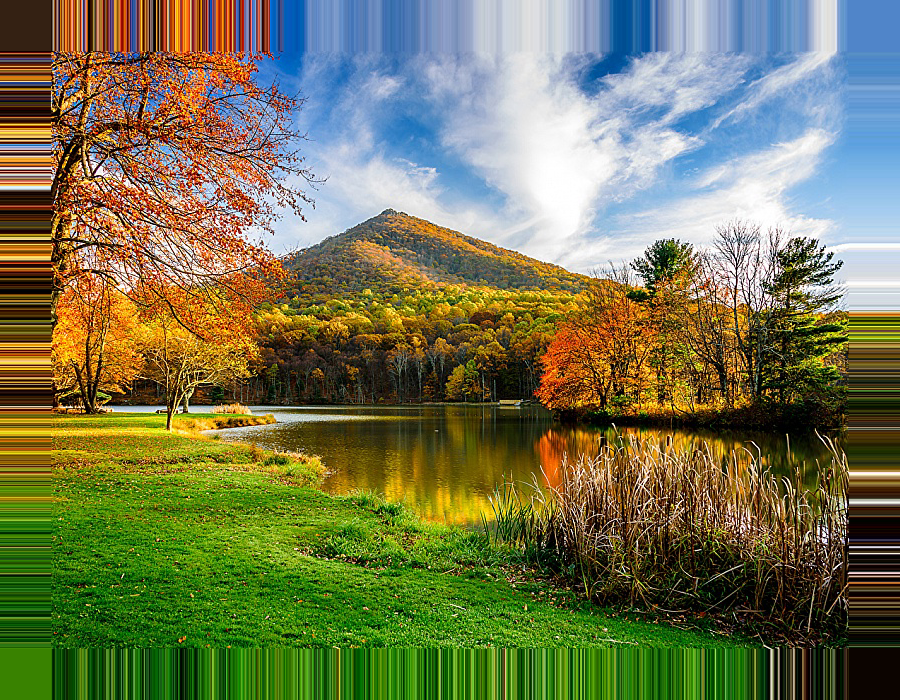

In [132]:
image = Image.open("image1.bmp") 
print(np.array(image).shape)
image_array = np.array(image)
Image.fromarray(pad_border(image_array, 50))

In [124]:
def median_blur_simple_sort(image_array, radius): 
    result = np.zeros_like(image_array)

    # Продлим изображение с помощью повторения границ
    image_array = pad_border(image_array, padding=radius)
    
    # Сделаем скользящее квадратное окно со стороной radius * 2 + 1. 
    # Это позволит нам легко итерироваться по таким окнам для реализации алгоритма
    a = radius * 2 + 1
    view = sliding_window_view(image_array, (a, a), axis=(0, 1))
    # print(view.shape)

    for i in range(result.shape[0]):
        for j in range(result.shape[1]):
            result[i][j] = np.median(view[i][j], axis=(1, 2))
    
    return result

In [401]:
def median_blur_huang(image_array, radius): 
    # Продлим изображение с помощью повторения границ
    image_array = pad_border(image_array, padding=radius)
    n_of_channels = image_array.shape[2]

    # Применим алгоритм Huang для каждого из каналов, а потом сформируем выходное изображение.
    channels = []

    def median_blur_huang_channel(image_array, radius):
        result = np.zeros((image_array.shape[0] - 2 * radius, image_array.shape[1] - 2 * radius), dtype='uint8')

        # Сделаем скользящее окно высотой (radius * 2 + 1) и шириной 1 
        # Это позволит нам легко итерироваться по таким окнам для реализации алгоритма
        a = radius * 2 + 1
        view = sliding_window_view(image_array, (a, 1), axis=(0, 1))
        median_position = a ** 2 // 2

        for i in range(result.shape[0]):
            # инициализируем гистограмму
            hist = np.zeros(256)
            for b in view[i, 0:a].reshape(-1):
                hist[b] += 1
            
            median = 0
            under_median = 0
            while under_median + hist[median] <= median_position:
                under_median += hist[median]
                median += 1

            result[i, 0] = median

            for j in range(1, result.shape[1]):
                left = view[i, j - 1]
                right = view[i, j + a - 1]
                
                # обновляем гистограмму
                values_l, counts_l = np.unique(left, return_counts=True)
                values_r, counts_r = np.unique(right, return_counts=True)
                
                hist[values_l] -= np.uint8(counts_l)
                hist[values_r] += np.uint8(counts_r)

                # сдвигаем медиану
                under_median -= np.sum(left < median)
                under_median += np.sum(right < median)

                if under_median <= median_position:
                    while under_median + hist[median] <= median_position:
                        under_median += hist[median]
                        median += 1
                else:
                    while under_median > median_position:
                        median -= 1
                        under_median -= hist[median]
                
                result[i, j] = median

        return result

    for i in range(n_of_channels):
        temp = median_blur_huang_channel(image_array[:, :, i], radius)
        channels.append(temp)

    return np.stack(channels,axis=2)

In [372]:
def process_image(image_array, method, radius):
    time_start = time.time()
    result_array = method(image_array, radius)
    speed = (time.time() - time_start) * 10e6 / (result_array.shape[0] * result_array.shape[1]) 
    return result_array, speed

In [407]:
from tqdm import tqdm

def test_algos(image_array, blur_methods, method_names, radii):
    measurements = pd.DataFrame(columns=['method', 'sec_to_megapixel', 'radius'])
    images = []

    for radius in tqdm(radii):
        reference_image, speed = process_image(image_array, cv.medianBlur, radius * 2 + 1)
        measurements = measurements.append({'method': 'cv', 'sec_to_megapixel': speed, 'radius': radius}, ignore_index=True)
        images.append(reference_image)

        for blur, method_name in zip(blur_methods, method_names):

            result_image, speed = process_image(image_array, blur, radius)
            # print(result_image.shape, reference_image.shape)
            # print(result_image - reference_image)
            assert np.allclose(result_image, reference_image)
            
            measurements = measurements.append({'method': method_name, 'sec_to_megapixel': speed, 'radius': radius}, ignore_index=True)
            images.append(result_image)

            print('R = {} | Method = {} | Speed = {} msec / megapixel'.format(radius, method_name, speed))

    return measurements, images

In [408]:
# radii = [1, 2, 3, 5, 8, 13, 21, 34, 55, 89, 144, 233, 377]
radii = [1, 2, 3, 5, 8, 13, 21] #, 34, 55, 89, 144]

blur_methods = [median_blur_simple_sort, median_blur_huang]
blur_methods_names = ['similar_sort', 'huang']

image_array_for_test = image_array[:200, :200]
# image_array_for_test = image_array

measurements, proccessed_images = test_algos(image_array_for_test, blur_methods, blur_methods_names, radii)

  0%|          | 0/7 [00:00<?, ?it/s]

R = 1 | Method = similar_sort | Speed = 521.8267440795898 msec / megapixel


 14%|█▍        | 1/7 [00:14<01:27, 14.63s/it]

R = 1 | Method = huang | Speed = 3133.0689787864685 msec / megapixel
R = 2 | Method = similar_sort | Speed = 548.6322641372681 msec / megapixel


 29%|██▊       | 2/7 [00:28<01:10, 14.17s/it]

R = 2 | Method = huang | Speed = 2912.3640656471252 msec / megapixel
R = 3 | Method = similar_sort | Speed = 529.4952392578125 msec / megapixel


 43%|████▎     | 3/7 [00:43<00:58, 14.52s/it]

R = 3 | Method = huang | Speed = 3200.199782848358 msec / megapixel
R = 5 | Method = similar_sort | Speed = 662.2772216796875 msec / megapixel


 57%|█████▋    | 4/7 [00:57<00:43, 14.54s/it]

R = 5 | Method = huang | Speed = 2974.798262119293 msec / megapixel
R = 8 | Method = similar_sort | Speed = 733.4847450256348 msec / megapixel


 71%|███████▏  | 5/7 [01:12<00:29, 14.52s/it]

R = 8 | Method = huang | Speed = 2886.907994747162 msec / megapixel
R = 13 | Method = similar_sort | Speed = 797.9467511177063 msec / megapixel


 86%|████████▌ | 6/7 [01:27<00:14, 14.79s/it]

R = 13 | Method = huang | Speed = 3023.135006427765 msec / megapixel
R = 21 | Method = similar_sort | Speed = 1383.5877776145935 msec / megapixel


100%|██████████| 7/7 [01:47<00:00, 15.38s/it]

R = 21 | Method = huang | Speed = 3574.5307207107544 msec / megapixel


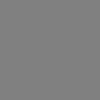

In [395]:
Image.fromarray(proccessed_images[1] - proccessed_images[0] + 128)

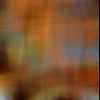

In [361]:
Image.fromarray(proccessed_images[1])

In [403]:
measurements

,method,sec_to_megapixel,radius
0,cv,0.612438,1
1,similar_sort,928.474963,1
2,huang,7889.655232,1
3,cv,0.901520,2
4,similar_sort,1062.786579,2
5,huang,4740.019143,2
6,cv,1.674891,3
7,similar_sort,783.658028,3
8,huang,3237.918019,3
9,cv,1.518428,5


In [ ]:
radii = [1, 2, 3, 5, 8, 13, 21, 34, 55, 89, 144]
# radii = [1, 2, 3, 5, 8, 13]

blur_methods = [median_blur_simple_sort, median_blur_huang]
blur_methods_names = ['similar_sort', 'huang']

# image_array_for_test = image_array[:100, :100]
image_array_for_test = image_array

measurements, proccessed_images = test_algos(image_array_for_test, blur_methods, blur_methods_names, radii)